# Perform a Split

One of the goals of machine learning is to build a model that performs well on new data. If you have new data, it’s a good idea to see how your model performs on it. The problem is that you may not have new data, but you can simulate this experience by splitting the dataset into train, validation and test sets. 

While performing supervised machine learning tasks, it is always recommended to split the data into three sets: training set, testing set and validation set. So, In the procedure when it comes to data split, first, we randomly split data into three sets:

**Training set**: A subset of the main dataset will feed into the model so that that model can learn the data patterns.

**Validation Set**: This set is used to understand the performance of the model in comparison to different models and hyperparameter choices.

**Test set**: This set checks the final model’s accuracy.

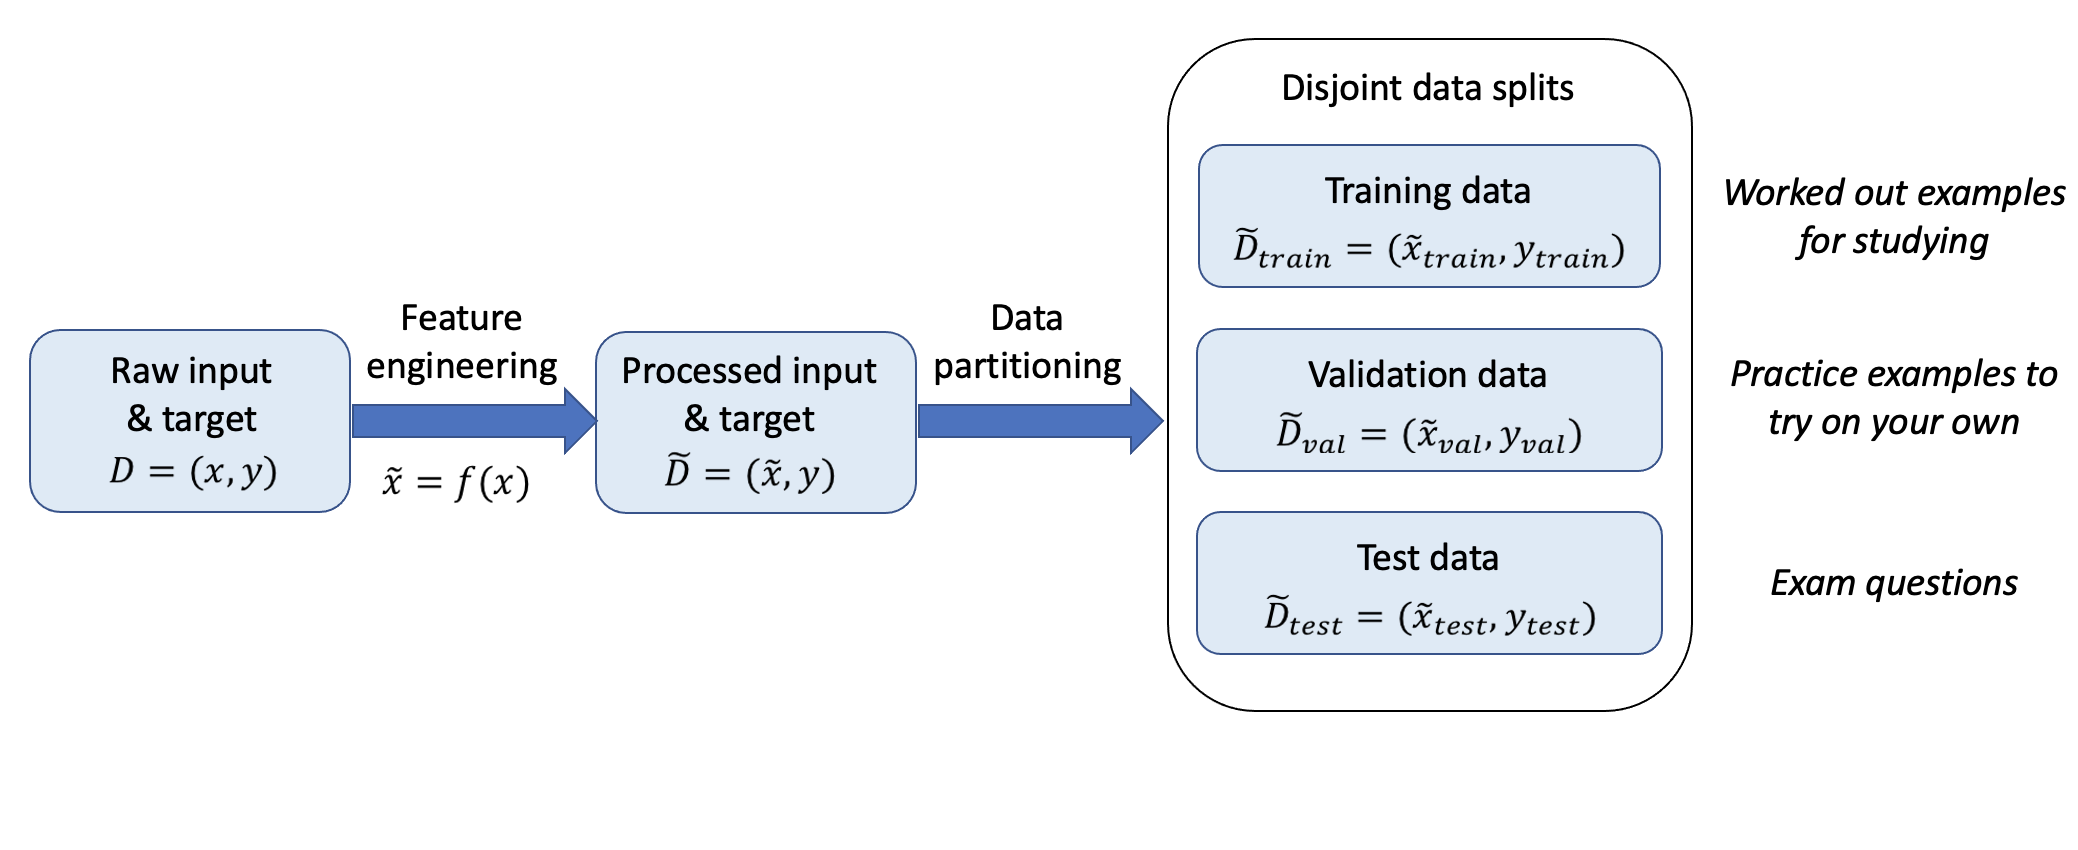

Performing a split helps the model validation process to simulate how your model would perform with new data. This tutorial will cover some tools in AMPL to perform a split.

Scaffold split
Rationale between nusing scaffold and random splits
Explain the split file format
Split only
Build the json

In [1]:
'''We will use the curated dataset that we created in tutorial 2 
and learn how to split it into tran,validation and test sets.'''

import pandas as pd
import numpy as np
import seaborn as sns

# Set up
dataset_file = 'dataset/curated_kcna5_ic50.csv'
odir='dataset'

In [2]:
# Read and view the curated dataset
kcna5 = pd.read_csv(dataset_file)
kcna5.head()

,compound_id,base_rdkit_smiles,relation,avg_pIC50
0,CHEMBL3785865,Cc1c(O)ccc2c1C(=O)N(Cc1ccccc1-c1ccccc1)C2C(=O)...,NaN,5.546093
1,CHEMBL512242,CCc1ccc(S(=O)(=O)N[C@@H]2c3cc(NC(=O)[C@H]4C[C@...,NaN,6.455932
2,CHEMBL396551,CCc1ccc(S(=O)(=O)N(CC(C)C)[C@@H]2c3cc(C(=O)NCC...,NaN,6.494850
3,CHEMBL572153,COc1ccc(CCN2C(=O)N(NS(C)(=O)=O)CC2c2ccc(C)cc2)cc1,NaN,6.619789
4,CHEMBL567244,CCn1c(C2=C(C)Nc3ccnn3C2c2ccc(Cl)c(Cl)c2)nc2cc(...,NaN,7.244125


/usr/WS1/hiran/ampl160/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='avg_pIC50', ylabel='Density'>

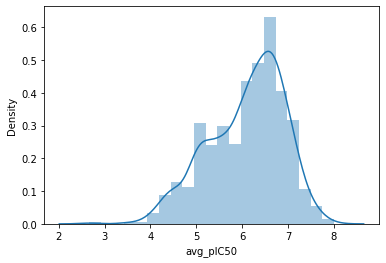

In [3]:
# Distribution of the avg_pIC50 values
sns.distplot(kcna5['avg_pIC50'])

Machine learning approaches aiming to learn relationships between molecules and the property in question can dramatically accelerate the screening process by recognizing abstract and higher-order molecular characteristics in already screened molecules associated with their bioactivity. This allows for better selectivity in future experiments, giving researchers information on which molecules are most and least likely to have the desired properties.

ML models, however, are as good as the data they were trained on. In the chemical space, this problem risks manifesting itself when a model is used to predict properties for molecules in an unfamiliar chemical space. If a model is trained only on molecules that belong to only a handful of scaffold classes, its ability to predict a molecule with an unfamiliar scaffold is unknown.

# Perform a Scaffold split

Scaffold split is based on the scaffold of the molecules. This makes sure that that the train/validation/test sets are more structurally different. 
It is more challenging than random split where the data is split into train/validation/test at random.


In [4]:
split_type=['scaffold','random']
param_lst=[]
for split_val in split_type :
    params = {
        "verbose": "True",
        "system": "LC",

        # dataset info
        "dataset_key" : dataset_file,
        "datastore": "False",
        "response_cols" : "avg_pIC50",
        "id_col": "compound_id",
        "smiles_col" : "base_rdkit_smiles",
        "result_dir": odir,

        # splitting
        "split_only": "True",
        "previously_split": "False",
        "splitter": split_val,
        "split_valid_frac": "0.15",
        "split_test_frac": "0.15",

        # featurization & training params
        "featurizer": "ecfp",
    }
    param_lst.append(params)

The dataset split table is saved as a .csv file in result_dir. The name of the split file contains the split type (scaffold/random) and the split_uuid; an unique identifier of the split.

In [5]:
from atomsci.ddm.pipeline import model_pipeline as mp
from atomsci.ddm.pipeline import parameter_parser as parse

split_lst=[]
for params in param_lst :
    pparams = parse.wrapper(params)
    MP = mp.ModelPipeline(pparams)
    # comment out this line after splitting once so you don't re-split
    split_uuid = MP.split_dataset()
    split_lst.append((params,split_uuid))

/usr/WS1/hiran/ampl160/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/usr/WS1/hiran/ampl160/lib/python3.9/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. jax requires jaxlib to be installed. See https://github.com/google/jax#installation for installation instructions.
INFO:ATOM:Created a dataset hash '2572ae8e1be18bea44d6c305227e4217' from dataset_key '/usr/WS1/hiran/dat

# Rationale between using scaffold split and random split

Model generalizability is an important feature to have and understand during the ML-assisted drug screening process. A generalizable model will be able to predict with high confidence the properties of molecules it has never seen before, reducing the need and pressure to perform extensive manual assays each time a new chemical class is to be tested. Generalizable models can predict across multiple different scaffolds and molecule types without prior screening, while a non-generalizable model requires manual generation of data for a new molecule class if accurate predictions are desired.

When the dataset is split using a scaffold split, the test set is structurally different than the training set and this helps with improving model generalizability. When using a random split, there is no guarantee that the test set will be structurally different than the training sets.

In [6]:
# display the split file location and names
import os
file_lst=[]
for params, sid in split_lst :
    fname=params['dataset_key']
    name=os.path.basename(fname)
    mid=name.split('.')[0]
    dirname = os.path.dirname(fname)
    split_val=params['splitter']
    nfile=dirname+'/'+mid+'_train_valid_test_'+split_val+'_'+sid+'.csv'
    file_lst.append((nfile,sid,split_val))
print(file_lst)

[('dataset/curated_kcna5_ic50_train_valid_test_scaffold_e44a5fc8-1944-4d36-8f10-aed0383432d1.csv', 'e44a5fc8-1944-4d36-8f10-aed0383432d1', 'scaffold'), ('dataset/curated_kcna5_ic50_train_valid_test_random_fe0024ce-e2e6-4645-90b7-b6246f0f7c4d.csv', 'fe0024ce-e2e6-4645-90b7-b6246f0f7c4d', 'random')]


# Format of the split file
The split file consits of three columns: cmpd_id is the compound id; subset tells you if the compound is in the train/validation/ test set and fold tell you which fold.

In [7]:
# Explore contents of the split file
df_lst=[]
for file,sid,split_val in file_lst :
    df=pd.read_csv(file)
    df_lst.append((df,sid,split_val))

In [8]:
df_lst

[(           cmpd_id subset  fold
  0    CHEMBL3785865  train     0
  1     CHEMBL396551  train     0
  2     CHEMBL572153  train     0
  3     CHEMBL567244  train     0
  4    CHEMBL2331983  train     0
  ..             ...    ...   ...
  797   CHEMBL217482   test     0
  798   CHEMBL465085   test     0
  799   CHEMBL604544   test     0
  800  CHEMBL1090159   test     0
  801  CHEMBL2312918   test     0
  
  [802 rows x 3 columns],
  'e44a5fc8-1944-4d36-8f10-aed0383432d1',
  'scaffold'),
 (           cmpd_id subset  fold
  0    CHEMBL3785865  train     0
  1     CHEMBL512242  train     0
  2     CHEMBL396551  train     0
  3     CHEMBL572153  train     0
  4     CHEMBL567244  train     0
  ..             ...    ...   ...
  797   CHEMBL433220   test     0
  798  CHEMBL1290282   test     0
  799   CHEMBL386899   test     0
  800   CHEMBL467671   test     0
  801   CHEMBL567025   test     0
  
  [802 rows x 3 columns],
  'fe0024ce-e2e6-4645-90b7-b6246f0f7c4d',
  'random')]

# Building a json file and the split_only flag

We can build a split config file and save it as a json file as shown below. The split_only flag can be set to True if you want to only split the dataset and not proceed with training. 

In [9]:
# Build the json
# an example of how to build a json using a split config file is shown below

import json

split_config = {
"dataset_key" : dataset_file,
"datastore": "False",
"split_only": "True",
"splitter": "scaffold",
"split_valid_frac": "0.15",
"split_test_frac": "0.15",
"previously_split": "False",
"response_cols" : "avg_pIC50",
"id_col": "compound_id",
"smiles_col" : "base_rdkit_smiles",
"result_dir": odir,
"featurizer": "ecfp",
"system": "LC",
"verbose": "True"
}

pparams = parse.wrapper(split_config)
MP = mp.ModelPipeline(pparams)
# comment out this line after splitting once so you don't re-split
split_uuid = MP.split_dataset()

config_path = "dataset/kcna5_chembl_scaffold_nn_split_config1.json"
with open(config_path, 'w') as out:
    json.dump(split_config, out, sort_keys=False, indent=4, separators=(',', ': '))
    print('Wrote %s' % config_path)

INFO:ATOM:Created a dataset hash '2572ae8e1be18bea44d6c305227e4217' from dataset_key '/usr/WS1/hiran/data_science/notebooks/PurdueDataMine/dataset/curated_kcna5_ic50.csv'
DEBUG:ATOM:Attempting to load featurized dataset
DEBUG:ATOM:Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
INFO:ATOM:Featurized dataset not previously saved for dataset curated_kcna5_ic50, creating new
INFO:ATOM:Featurizing sample 0
DEBUG:ATOM:Number of features: 1024


Wrote dataset/kcna5_chembl_scaffold_nn_split_config1.json
